In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display

import dynamiqs as dq
from functools import reduce
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam

|██████████| 100.0% ◆ elapsed 217.41ms ◆ remaining 0.00ms 


/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


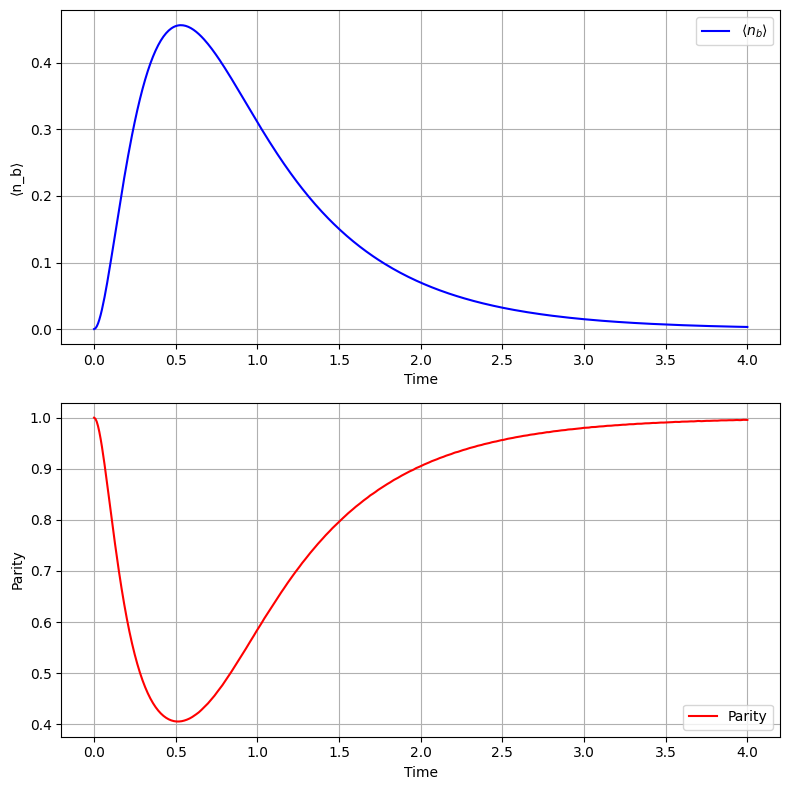

In [11]:
## Task 1.1 - Getting started with 'dynamiqs'
# Hilbert space truncations
na = 20   # Buffer mode a - encodes the logical cat qubit
nb = 5    # Memory mode b - mediates 2-photon dissipation to stabilize the cat state

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Memory mode a annihilation operator
adag = a.dag()                                # Memory mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Buffer mode b annihilation operator
bdag = b.dag()                                # Buffer mode b creation operator

# More parameters
g_2 = 1.0                          # 2-photon exchange coupling strength between the memory and buffer modes
eps_d = -4.0                       # Coherent drive applied to the buffer mode
kappa_b = 10 * g_2                 # Decay rate of the buffer mode
n_b = bdag @ b                     # Photon number operator for the buffer mode
T = 4                              # Time for simulation [s]
t_save = jnp.linspace(0, T, 500)   # Time array for the master equation to return with. Used with 500 intervals

# Hamiltonian construction
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)   # 2-photon exchange Hamiltonian - couples the memory and buffer modes
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag                           # 1-photon drive Hamiltonian - supplies the photons so that the memory mode can end up in a cat state
H = H_2ph + H_d                                                         # Stabilized Hamiltonian - missing a Zeno gate rotation used in Task 1.2

# Initial state, collapse operator, and resulting states
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))   # Vacuum state initialization - creates the memory and buffer modes with 0 photons each
c_ops = [jnp.sqrt(kappa_b) * b]                    # Collapse operator on the buffer mode - 1-photon loss as a result of decay from this operator
result = dq.mesolve(H, c_ops, psi0, t_save)        # Solves the Linblad master equation - returns the time evolution of the density matrix for each time step   

# Parity and expectation values
terms = [(-1)**n * dq.fock_dm(nb, n) for n in range(nb)]                    # Creates Fock-state projectors with alternating signs
parity_b_local = reduce(lambda a, b: a + b, terms)                          # The actual buffer mode parity operator - returns +1 when number of photons is even and -1 when odd
parity_b = dq.tensor(dq.eye(na), parity_b_local)                            # Embeds the buffer mode parity operator into the full 2-mode Hilbert space - This is basically the parity operator on the buffer mode and leaves the memory mode the same
n_b_expect = [dq.expect(n_b, state) for state in result.states]             # Calculates the expectation value from the resulting states using the photon number operator for the buffer mode
parity_b_expect = [dq.expect(parity_b, state) for state in result.states]   # Calculates the expectation value from the resulting states using the parity operator for the buffer mode

# Animation plotting
fig_w, ax_w = plt.subplots(1, 1, figsize=(8, 8)) 
def update(frame):   # Updates the animation when 
    ax_w.cla()                                                                          # Clears the axis
    rho_a = dq.ptrace(result.states[frame], 0)                                          # Partial trace over the buffer mode to extract the reduced state of the memory mode
    dq.plot.wigner(rho_a, ax=ax_w)                                                      # Plots the Wigner function for the reduced state above, rho_a
    ax_w.set_title(f"Memory Mode of the Wigner Function\nTime = {t_save[frame]:.2f}")   # Sets the title of the animation

ani = FuncAnimation(fig_w, update, frames=len(t_save), repeat=False)   # Creates the animation
gif_filename = 'Task1.1.gif'                                           # Animation file name
ani.save(gif_filename, writer=PillowWriter(fps=50))                    # Saves the animation to the same directory that this file is in
plt.close(fig_w)                                                       # Closes the file in matplotlib to free up memory 
display(HTML(f'<img src="{gif_filename}">'))                           # Displays the animation file

# Plotting the expectation value of the photon number in the buffer mode
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))                        # Lets us create a stacked plot for the expectation value and the photon number parity
ax1.plot(t_save, n_b_expect, label=r'$\langle n_b \rangle$', color='blue')   # Creates the expectation value plot
ax1.set_xlabel('Time')                                                       # Sets the x label for the plot
ax1.set_ylabel('⟨n_b⟩')                                                      # Sets the y label for the plot
ax1.legend()                                                                 # Adds a legend to the plot
ax1.grid(True)                                                               # Adds a grid to the plot

# Plotting the photon number parity in the buffer mode
ax2.plot(t_save, parity_b_expect, label='Parity', color='red')   # Creates the photon number parity plot
ax2.set_xlabel('Time')                                           # Sets the x label for the plot
ax2.set_ylabel('Parity')                                         # Sets the y label for the plot
ax2.legend()                                                     # Adds a legend to the plot
ax2.grid(True)                                                   # Adds a grid to the plot

plt.tight_layout()   # Adjusts spacing between plotted elements
plt.show()           # Shows all plots

|██████████| 100.0% ◆ elapsed 248.30ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 213.78ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 242.17ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 124.74ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 210.46ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 76.53ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 194.10ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 61.71ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 193.71ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 53.63ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 205.47ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 44.74ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 208.94ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 37.68ms ◆ remaining 0.00ms


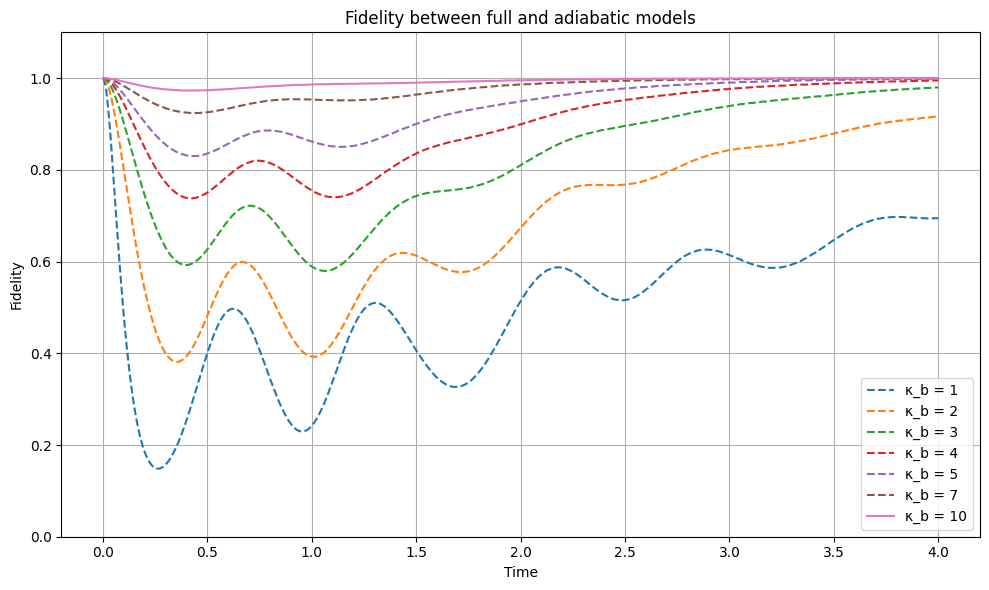

In [12]:
## Task 1.2 - Comparison with eliminated buffer mode
# Hilbert space truncations
na = 20   # Buffer mode a - encodes the logical cat qubit
nb = 5    # Memory mode b - mediates 2-photon dissipation to stabilize the cat state

# More paramters
g_2 = 1.0                          # 2-photon exchange coupling strength between the memory and buffer modes
eps_d = -4.0                       # Coherent drive applied to the buffer mode
T = 4                              # Time for simulation [s]
t_save = jnp.linspace(0, T, 500)   # Time array for the master equation to return with. Used with 500 intervals

# kappa_b values to test and compare with original value from Task 1.1
kappa_b_values = jnp.array([1, 2, 3, 4, 5, 7, 10]) 

# Plotting
plt.figure(figsize=(10, 6))
for kappa_b in kappa_b_values:
    # Operators in the composite Hilbert space
    a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Memory mode a annihilation operator
    adag = a.dag()                                # Memory mode a creation operator
    b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Buffer mode b annihilation operator
    bdag = b.dag()                                # Buffer mode b creation operator
    
    # Hamiltonian construction
    H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)   # 2-photon exchange Hamiltonian - couples the memory and buffer modes
    H_d = jnp.conjugate(eps_d) * b + eps_d * bdag                           # 1-photon drive Hamiltonian - supplies the photons so that the memory mode can end up in a cat state
    H = H_2ph + H_d                                                         # Stabilized Hamiltonian - missing a Zeno gate rotation used in Task 1.2
    
    # Initial state, collapse operator, resulting states, and final memory mode information
    psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))                # Vacuum state initialization - creates the memory and buffer modes with 0 photons each
    c_ops = [jnp.sqrt(kappa_b) * b]                                 # Collapse operator on the buffer mode - 1-photon loss as a result of decay from this operator
    result = dq.mesolve(H, c_ops, psi0, t_save)                     # Solves the Linblad master equation - returns the time evolution of the density matrix for each time step   
    rho_a_list = [dq.ptrace(state, 0) for state in result.states]   # Get reduced states of the memory mode by discarding the buffer mode's quantum information

    # Effective parameters
    kappa_2 = 4 * abs(g_2)**2 / kappa_b      # 2-photon dissipation rate
    alpha_sq = -eps_d / jnp.conjugate(g_2)   # Squared coherent‐state amplitude
    alpha = jnp.sqrt(alpha_sq)               # Coherent‐state amplitude
    
    # Effective operators
    a_eff = dq.destroy(na)                                                # Effective single-mode annihilation operator - acts on the memory mode in the adiabatically eliminated model
    L_eff = jnp.sqrt(kappa_2) * (a_eff @ a_eff - alpha_sq * dq.eye(na))   # Effective memory mode collapse operator - responsible for stabilization
    
    # Effective system results and fidelity
    result_eff = dq.mesolve(dq.zeros(na), [L_eff], dq.fock(na, 0), t_save)   # Solves the effective 1-mode system and returns a list of density matrices
    fidelity = [dq.fidelity(rho_a, rho_eff)                                  # Captures how close the memory mode from the full simulation is to the 1‐mode
                for rho_a, rho_eff in zip(rho_a_list, result_eff.states)]    # solution from the adiabatically eliminated approach at each time step
    
    # Plot results
    plt.plot(t_save, fidelity, label=f'κ_b = {kappa_b}',
             linestyle='--' if kappa_b < 10 else '-')

# Plot formatting
plt.xlabel('Time')                                        # Sets the x label for the plot
plt.ylabel('Fidelity')                                    # Sets the y label for the plot
plt.ylim(0, 1.1)                                          # Sets the y limits for the plot
plt.title('Fidelity between full and adiabatic models')   # Sets the title of the plot
plt.legend()                                              # Adds a legend to the plot
plt.grid(True)                                            # Adds a grid to the plot

plt.tight_layout()   # Adjusts spacing between plotted elements
plt.show()           # Shows all plots

In [14]:
## Task 1.3 - Performing a Zeno-gate
# Hilbert space truncations
na = 20   # Buffer mode a - encodes the logical cat qubit
nb = 5    # Memory mode b - mediates 2-photon dissipation to stabilize the cat state

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Memory mode a annihilation operator
adag = a.dag()                                # Memory mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Buffer mode b annihilation operator
bdag = b.dag()                                # Buffer mode b creation operator

# More parameters
g_2 = 1.0
eps_d = -4.0
kappa_b = 10.0

# Stabilized Hamiltonian construction
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (bdag @ a @ a) 
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag
H_stab = H_2ph + H_d

# -------------------------------
# 4. Define the Zeno gate Hamiltonian (rotation about Z)
# -------------------------------
# This Hamiltonian is given by:
#   H_Z = epsilon_Z^* a^2 + epsilon_Z a†^2
epsilon_Z = 0.2 + 0.0j   # Gate drive amplitude (adjust to set rotation speed)
H_Z = jnp.conjugate(epsilon_Z) * (a @ a) + epsilon_Z * (adag @ adag)

# -------------------------------
# 5. Total Hamiltonian for gate simulation
# -------------------------------
H_total = H_stab + H_Z

# -------------------------------
# 6. Define the initial state: even cat state in the memory mode
# -------------------------------
# Define α = 2 (so that α² = 4)
alpha = 2.0
# Construct coherent states |α> and |−α>
coherent_plus = dq.coherent(na, alpha)
coherent_minus = dq.coherent(na, -alpha)
# The even cat state (logical |+⟩) is proportional to |α> + |−α>
cat_plus = (coherent_plus + coherent_minus).unit()
# Embed the memory state into the full composite space (buffer in vacuum)
psi0 = dq.tensor(cat_plus, dq.fock(nb, 0))

# -------------------------------
# 7. Define time evolution parameters for the gate simulation
# -------------------------------
# Let T_gate be the time for a π rotation (half a full rotation period)
T_gate = 5.0   # Adjust T_gate so that a π rotation (|+⟩ -> |−⟩) is achieved.
t_save = jnp.linspace(0, T_gate, 500)

# -------------------------------
# 8. Define collapse operator (buffer decay only, as in Task 1.1)
# -------------------------------
c_ops = [jnp.sqrt(kappa_b) * b]

# -------------------------------
# 9. Solve the Lindblad master equation with H_total
# -------------------------------
res = dq.mesolve(H_total, c_ops, psi0, t_save)

# -------------------------------
# 10. Create the GIF: Compute the Wigner function of the memory mode (by tracing out the buffer)
# -------------------------------
fig_w, ax_w = plt.subplots(1, 1, figsize=(6, 6))
def update(frame):
    ax_w.cla()  # Clear previous frame
    # Extract the reduced density matrix for the memory mode:
    rho_a = dq.ptrace(res.states[frame], 0)
    # Plot the Wigner function for the memory mode:
    dq.plot.wigner(rho_a, ax=ax_w)
    ax_w.set_title(f"Memory Mode Wigner Function\nTime = {t_save[frame]:.2f}")

ani = FuncAnimation(fig_w, update, frames=len(t_save), repeat=False)
gif_filename = 'wigner_memory_mode_Zeno.gif'
ani.save(gif_filename, writer=PillowWriter(fps=50))

plt.close(fig_w)
display(HTML(f'<img src="{gif_filename}">'))

|██████████| 100.0% ◆ elapsed 309.28ms ◆ remaining 0.00ms  


|██████████| 100.0% ◆ elapsed 11.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 11.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.21ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.95ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 36.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.95ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.30ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.32ms ◆ remaining 0.00ms


Initial loss = 0.019729078


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 60.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 30.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.66ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.92ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 154.45ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 185.44ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 202.50ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.37ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.95ms ◆ remaining 0.00ms


Iteration:   0 | Loss: 0.0197


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 53.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.28ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.16ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 129.25ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 141.84ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 151.50ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.29ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.75ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.43ms ◆ remaining 0.00ms


Iteration:   1 | Loss: 0.0185


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 61.94ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.17ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.04ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 135.01ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 165.01ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 159.10ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.04ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.39ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.56ms ◆ remaining 0.00ms


Iteration:   2 | Loss: 0.0165


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 54.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 11.53ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.63ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.29ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 126.35ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 161.83ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 155.91ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.07ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.37ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.45ms ◆ remaining 0.00ms


Iteration:   3 | Loss: 0.0150


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 53.80ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 12.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 128.39ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 163.05ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 179.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.89ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.23ms ◆ remaining 0.00ms


Iteration:   4 | Loss: 0.0136


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 56.15ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.18ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.50ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 141.92ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 171.91ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 168.43ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.60ms ◆ remaining 0.00ms


Iteration:   5 | Loss: 0.0123


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 51.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 14.69ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.72ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 127.22ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 161.44ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 178.96ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 14.90ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.41ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.24ms ◆ remaining 0.00ms


Iteration:   6 | Loss: 0.0114


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 56.74ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.91ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.94ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 133.43ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 167.14ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 173.49ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.27ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.31ms ◆ remaining 0.00ms


Iteration:   7 | Loss: 0.0106


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 62.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.93ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 36.05ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 166.99ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 162.84ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 214.48ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 34.61ms ◆ remaining 0.00ms


Iteration:   8 | Loss: 0.0097


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 38.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 35.07ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.25ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 138.82ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 158.46ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 173.05ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.50ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.48ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.52ms ◆ remaining 0.00ms


Iteration:   9 | Loss: 0.0091


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 62.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.07ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.95ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.22ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 141.74ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 150.81ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 156.65ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.54ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.61ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.24ms ◆ remaining 0.00ms


Iteration:  10 | Loss: 0.0086


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 63.66ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.41ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.54ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 143.53ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 177.76ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 191.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.76ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.20ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.28ms ◆ remaining 0.00ms


Iteration:  11 | Loss: 0.0081


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 63.47ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.11ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.98ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.17ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 167.89ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 166.36ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 177.87ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.03ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.88ms ◆ remaining 0.00ms


Iteration:  12 | Loss: 0.0078


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 39.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 39.97ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.95ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 145.31ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 160.32ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 172.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 36.16ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.86ms ◆ remaining 0.00ms


Iteration:  13 | Loss: 0.0076


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 40.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 30.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.54ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 142.93ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 162.15ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 198.49ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.74ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.17ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.23ms ◆ remaining 0.00ms


Iteration:  14 | Loss: 0.0074


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 54.92ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.74ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.62ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 140.60ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 156.68ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 186.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.05ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.95ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.50ms ◆ remaining 0.00ms


Iteration:  15 | Loss: 0.0072


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 56.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.01ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.73ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 139.13ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 155.88ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 191.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.64ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.98ms ◆ remaining 0.00ms


Iteration:  16 | Loss: 0.0072


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 57.74ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.78ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.52ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 140.06ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 176.61ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 193.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.72ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.36ms ◆ remaining 0.00ms


Iteration:  17 | Loss: 0.0071


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 56.73ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.20ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.12ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.60ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 143.25ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 162.36ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 183.49ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.85ms ◆ remaining 0.00ms


Iteration:  18 | Loss: 0.0070


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 53.53ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.53ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 140.58ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 175.69ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 191.31ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.59ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.01ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.90ms ◆ remaining 0.00ms


Iteration:  19 | Loss: 0.0069


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 65.49ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.74ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.27ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.90ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 145.33ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 156.48ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 166.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.03ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.40ms ◆ remaining 0.00ms


Iteration:  20 | Loss: 0.0069


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 56.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.21ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.89ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 141.37ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 158.85ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 192.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.65ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.38ms ◆ remaining 0.00ms


Iteration:  21 | Loss: 0.0068


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 67.65ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.98ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.21ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 155.60ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 172.02ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 185.99ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.71ms ◆ remaining 0.00ms


Iteration:  22 | Loss: 0.0067


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 59.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.03ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.78ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 146.01ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 176.83ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 192.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.01ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.90ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.83ms ◆ remaining 0.00ms


Iteration:  23 | Loss: 0.0067


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 59.15ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.91ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.15ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.44ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 141.32ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 174.43ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 188.96ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.47ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.12ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.34ms ◆ remaining 0.00ms


Iteration:  24 | Loss: 0.0067


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 57.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.65ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.03ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 145.28ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 156.09ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 173.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.81ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.48ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.07ms ◆ remaining 0.00ms


Iteration:  25 | Loss: 0.0067


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 56.68ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.26ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.41ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.91ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 139.78ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 157.82ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 184.77ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.29ms ◆ remaining 0.00ms


Iteration:  26 | Loss: 0.0067


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 64.47ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.68ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 40.94ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 176.88ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 194.05ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 205.17ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.29ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.89ms ◆ remaining 0.00ms


Iteration:  27 | Loss: 0.0067


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 66.93ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.71ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.25ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 175.68ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 174.74ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 186.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 33.33ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.65ms ◆ remaining 0.00ms


Iteration:  28 | Loss: 0.0067


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 43.18ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.98ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 40.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 24.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 162.49ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 179.47ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 194.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 14.16ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 45.92ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.46ms ◆ remaining 0.00ms


Iteration:  29 | Loss: 0.0066


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 71.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.52ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 30.60ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.33ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 167.28ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 188.33ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 202.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.41ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.50ms ◆ remaining 0.00ms


Iteration:  30 | Loss: 0.0066


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 49.65ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 36.64ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.68ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.07ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 185.67ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 203.01ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 220.39ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 39.12ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.98ms ◆ remaining 0.00ms


Iteration:  31 | Loss: 0.0066


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 70.01ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.24ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 31.60ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 182.20ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 200.57ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 211.20ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.59ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 24.55ms ◆ remaining 0.00ms


Iteration:  32 | Loss: 0.0066


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 69.29ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.31ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.87ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.12ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 179.23ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 195.30ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 228.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.97ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.65ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.02ms ◆ remaining 0.00ms


Iteration:  33 | Loss: 0.0066


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 48.51ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 42.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.99ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 181.56ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 197.40ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 235.20ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.14ms ◆ remaining 0.00ms


Iteration:  34 | Loss: 0.0065


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 63.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.94ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.11ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 181.39ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 198.63ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 223.53ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.47ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.87ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.02ms ◆ remaining 0.00ms


Iteration:  35 | Loss: 0.0065


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 60.94ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.26ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.98ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 179.28ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 199.10ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 224.13ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.72ms ◆ remaining 0.00ms


Iteration:  36 | Loss: 0.0065


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 62.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.22ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 40.83ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 171.72ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 184.96ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 193.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.12ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 43.80ms ◆ remaining 0.00ms


Iteration:  37 | Loss: 0.0065


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 60.26ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.17ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.03ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.21ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 170.35ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 186.50ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 219.89ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.77ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.44ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.34ms ◆ remaining 0.00ms


Iteration:  38 | Loss: 0.0065


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 46.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.97ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.24ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 178.44ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 195.09ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 230.57ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.33ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.19ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.23ms ◆ remaining 0.00ms


Iteration:  39 | Loss: 0.0064


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 65.74ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.29ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 35.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 179.80ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 215.40ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 203.26ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 36.77ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.25ms ◆ remaining 0.00ms


Iteration:  40 | Loss: 0.0064


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 63.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.14ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 175.63ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 193.55ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 225.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.06ms ◆ remaining 0.00ms


Iteration:  41 | Loss: 0.0064


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 68.04ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.61ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.49ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 46.18ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 184.59ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 237.33ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 229.95ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.17ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 35.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.51ms ◆ remaining 0.00ms


Iteration:  42 | Loss: 0.0064


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 65.68ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.57ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 24.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 44.25ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 182.49ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 208.52ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 303.63ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.31ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.86ms ◆ remaining 0.00ms


Iteration:  43 | Loss: 0.0064


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 44.28ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 47.22ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.03ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.89ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 167.28ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 202.62ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 218.17ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 14.87ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.19ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.71ms ◆ remaining 0.00ms


Iteration:  44 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 37.59ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 39.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 142.34ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 156.43ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 189.10ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 14.30ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.50ms ◆ remaining 0.00ms


Iteration:  45 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 57.14ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.24ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 171.79ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 189.98ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 208.90ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 37.39ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.98ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.85ms ◆ remaining 0.00ms


Iteration:  46 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 72.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 29.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 46.94ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.84ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 205.55ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 192.75ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 222.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.48ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.23ms ◆ remaining 0.00ms


Iteration:  47 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 65.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.37ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.15ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 172.42ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 189.47ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 182.43ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.39ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.79ms ◆ remaining 0.00ms


Iteration:  48 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 39.04ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.44ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 28.97ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.05ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 143.21ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 159.16ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 192.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.15ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.72ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.13ms ◆ remaining 0.00ms


Iteration:  49 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 57.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.62ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 142.66ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 179.17ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 194.13ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.25ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.87ms ◆ remaining 0.00ms


Iteration:  50 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 41.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.19ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 35.48ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 148.45ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 165.61ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 197.16ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.66ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.66ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.86ms ◆ remaining 0.00ms


Iteration:  51 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 59.13ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.19ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.97ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 148.54ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 182.62ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 198.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 14.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.33ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.12ms ◆ remaining 0.00ms


Iteration:  52 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 41.81ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.03ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 39.66ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 145.05ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 162.13ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 197.78ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.65ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.13ms ◆ remaining 0.00ms


Iteration:  53 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 68.20ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.04ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.50ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 172.72ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 173.51ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 179.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 36.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.01ms ◆ remaining 0.00ms


Iteration:  54 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 62.37ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.10ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.83ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.28ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 156.65ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 191.15ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 204.71ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 14.28ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.79ms ◆ remaining 0.00ms


Iteration:  55 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 42.50ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.27ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 148.01ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 166.09ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 198.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.33ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.41ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.74ms ◆ remaining 0.00ms


Iteration:  56 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 67.11ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.74ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.68ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.91ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 170.01ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 189.59ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 177.05ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 40.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.11ms ◆ remaining 0.00ms


Iteration:  57 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 64.21ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.96ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.97ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 151.96ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 186.48ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 201.48ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.22ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.26ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.35ms ◆ remaining 0.00ms


Iteration:  58 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 53.28ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.31ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.22ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 158.06ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 173.90ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 210.05ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.75ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.92ms ◆ remaining 0.00ms


Iteration:  59 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 58.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.94ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.31ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 164.50ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 185.33ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 173.78ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.52ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 26.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.66ms ◆ remaining 0.00ms


Iteration:  60 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 46.04ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 26.90ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 152.45ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 167.68ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 203.64ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.12ms ◆ remaining 0.00ms


Iteration:  61 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 63.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.04ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.51ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.44ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 152.22ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 188.56ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 203.66ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.20ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.76ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.35ms ◆ remaining 0.00ms


Iteration:  62 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 46.39ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.69ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 40.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.16ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 153.38ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 171.41ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 205.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.03ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.25ms ◆ remaining 0.00ms


Iteration:  63 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 61.90ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.13ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.48ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.41ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 164.66ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 182.73ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 190.54ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 43.51ms ◆ remaining 0.00ms


Iteration:  64 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 46.07ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.73ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.90ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.26ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 154.14ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 170.37ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 205.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.44ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.84ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.52ms ◆ remaining 0.00ms


Iteration:  65 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 58.90ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.20ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.78ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 142.97ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 176.36ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 164.47ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.54ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.77ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.68ms ◆ remaining 0.00ms


Iteration:  66 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 42.15ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.64ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 33.40ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 140.58ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 156.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 199.52ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.49ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.64ms ◆ remaining 0.00ms


Iteration:  67 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 56.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.27ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.24ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 138.16ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 171.99ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 188.92ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.84ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.28ms ◆ remaining 0.00ms


Iteration:  68 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 42.73ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.11ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 35.50ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 141.35ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 157.78ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 191.59ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.51ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.93ms ◆ remaining 0.00ms


Iteration:  69 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 58.60ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.83ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.63ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.75ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 161.74ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 179.56ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 195.54ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.52ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 36.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.62ms ◆ remaining 0.00ms


Iteration:  70 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 59.08ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.92ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.87ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.77ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 141.92ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 177.27ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 192.83ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.12ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.67ms ◆ remaining 0.00ms


Iteration:  71 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 41.53ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.64ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.93ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 31.69ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 142.98ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 158.51ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 175.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 34.96ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.30ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.98ms ◆ remaining 0.00ms


Iteration:  72 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 59.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.18ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.11ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 144.86ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 179.66ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 196.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.99ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.84ms ◆ remaining 0.00ms


Iteration:  73 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 41.37ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.15ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.24ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 28.63ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 143.00ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 157.16ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 190.24ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.54ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.87ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.77ms ◆ remaining 0.00ms


Iteration:  74 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 66.37ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.41ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.76ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.83ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 176.13ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 191.66ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 185.76ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.62ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 33.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.15ms ◆ remaining 0.00ms


Iteration:  75 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 57.89ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.52ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 140.80ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 174.30ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 191.43ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.14ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.15ms ◆ remaining 0.00ms


Iteration:  76 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 42.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.30ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.53ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 31.71ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 143.97ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 160.16ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 177.01ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 35.62ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.91ms ◆ remaining 0.00ms


Iteration:  77 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 57.26ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.15ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.33ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 140.38ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 174.70ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 189.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.07ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.60ms ◆ remaining 0.00ms


Iteration:  78 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 40.89ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.11ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 39.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 142.67ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 158.47ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 191.33ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.72ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.24ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.71ms ◆ remaining 0.00ms


Iteration:  79 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 62.48ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.76ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.43ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 161.58ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 175.49ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 163.83ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.54ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 30.61ms ◆ remaining 0.00ms


Iteration:  80 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 41.37ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 35.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 143.74ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 158.35ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 194.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.39ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.33ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.79ms ◆ remaining 0.00ms


Iteration:  81 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 58.20ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.35ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 24.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 144.00ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 178.13ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 195.31ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.91ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.17ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.43ms ◆ remaining 0.00ms


Iteration:  82 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 39.01ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 14.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 138.68ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 155.74ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 189.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.27ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.31ms ◆ remaining 0.00ms


Iteration:  83 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 59.99ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.84ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.60ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 142.57ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 175.81ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 192.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.92ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.76ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.92ms ◆ remaining 0.00ms


Iteration:  84 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 47.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.29ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 31.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 147.12ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 162.72ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 183.48ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.97ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.79ms ◆ remaining 0.00ms


Iteration:  85 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 61.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.11ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.29ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.82ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 142.06ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 175.29ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 189.26ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.93ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.61ms ◆ remaining 0.00ms


Iteration:  86 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 44.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.77ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.12ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 144.60ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 159.96ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 195.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.25ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.66ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.99ms ◆ remaining 0.00ms


Iteration:  87 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 66.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 150.58ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 186.25ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 194.83ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.78ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.67ms ◆ remaining 0.00ms


Iteration:  88 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 41.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 40.39ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.30ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 143.88ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 159.06ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 193.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.96ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.55ms ◆ remaining 0.00ms


Iteration:  89 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 59.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.10ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.39ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.19ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 159.86ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 177.02ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 170.64ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.08ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 35.76ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.56ms ◆ remaining 0.00ms


Iteration:  90 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 66.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.76ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.49ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.77ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 149.34ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 184.32ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 200.27ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.37ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.50ms ◆ remaining 0.00ms


Iteration:  91 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 48.34ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.49ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 40.04ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 154.66ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 170.16ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 204.45ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.85ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.81ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.83ms ◆ remaining 0.00ms


Iteration:  92 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 68.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.23ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.68ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.86ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 176.03ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 191.72ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 186.73ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.91ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.02ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.84ms ◆ remaining 0.00ms


Iteration:  93 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 62.78ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.16ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.99ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.19ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 149.14ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 184.03ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 201.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.66ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.39ms ◆ remaining 0.00ms


Iteration:  94 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 41.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.30ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 40.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 147.43ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 164.74ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 200.08ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.50ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.41ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.76ms ◆ remaining 0.00ms


Iteration:  95 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 61.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.00ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.01ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 145.91ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 182.47ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 198.96ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.52ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.55ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.93ms ◆ remaining 0.00ms


Iteration:  96 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 46.88ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 37.43ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 154.35ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 170.30ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 203.20ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.41ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.57ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.07ms ◆ remaining 0.00ms


Iteration:  97 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 64.52ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.78ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.60ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 19.51ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 155.58ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 190.94ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 184.61ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.19ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 17.75ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.19ms ◆ remaining 0.00ms


Iteration:  98 | Loss: 0.0063


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?


|██████████| 100.0% ◆ elapsed 42.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 15.64ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.81ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 143.85ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 161.02ms ◆ remaining 0.00ms




|██████████| 100.0% ◆ elapsed 196.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.92ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.69ms ◆ remaining 0.00ms


Iteration:  99 | Loss: 0.0063


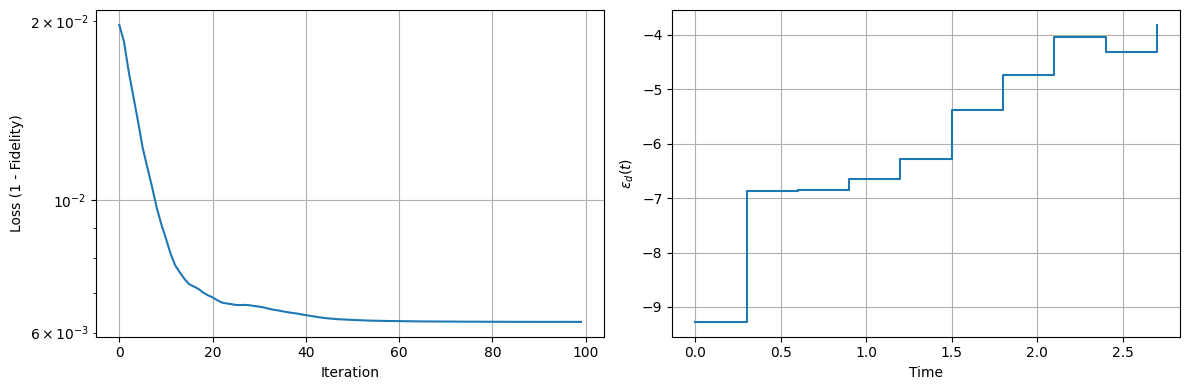

In [15]:
## Task 1.4 - Optimal control for state-preparation
# Hilbert space truncations
na = 20   # Buffer mode a - encodes the logical cat qubit
nb = 5    # Memory mode b - mediates 2-photon dissipation to stabilize the cat state

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))   # Memory mode a annihilation operator
adag = a.dag()                              # Memory mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))   # Buffer mode b annihilation operator
bdag = b.dag()                              # Buffer mode b creation operator

# More paramters
g_2 = 1.0        # 2-photon exchange coupling strength between the memory and buffer modes
kappa_b = 10.0   # Decay rate of the buffer mode
alpha = 2.0      # Coherent‐state amplitude

# Creates a picewise constant time array 
T = 3.0                                 # Time for simulation [s]
N_bins = 10                             # Number of bins to divide the time into
t_bins = jnp.linspace(0, T, N_bins+1)   # Bin boundaries
dt = T / N_bins                         # Time step

# 2-photon Hamiltonian construction
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)

# Initial state and collapse operator
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))   # Vacuum state initialization - creates the memory and buffer modes with 0 photons each
c_ops = [jnp.sqrt(kappa_b) * b]                    # Collapse operator on the buffer mode - 1-photon loss as a result of decay from this operator

# Coherent state construction of the memory mode
coherent_plus = dq.coherent(na, alpha)
coherent_minus = dq.coherent(na, -alpha)
cat_state = coherent_plus + coherent_minus
cat_even = dq.unit(cat_state)

# Loss function (1 - fidelity)
def loss_function(eps_d_values):
    state = psi0
    for i in range(N_bins):
        H_d = eps_d_values[i] * (b + bdag)
        H = H_2ph + H_d
        result = dq.mesolve(H, c_ops, state, jnp.array([0.0, dt]))
        state = result.states[-1]
    rho_a = dq.ptrace(state, 0)
    return 1.0 - dq.fidelity(rho_a, cat_even)

# Initialize optimizer
opt_init, opt_update, get_params = adam(step_size=0.1)
eps_d_init = -(alpha**2) * jnp.ones(N_bins)
opt_state = opt_init(eps_d_init)
print("Initial loss =", loss_function(eps_d_init))

# JIT-compiled optimization step
@jax.jit
def step(opt_state, _):
    params = get_params(opt_state)
    loss_value, grads = jax.value_and_grad(loss_function)(params)
    opt_state = opt_update(0, grads, opt_state)
    return opt_state, loss_value

# Run optimization
loss_history = []
for i in range(100):     # 100 b/c 200 took too long to run
    opt_state, loss_value = step(opt_state, None)
    loss_history.append(float(loss_value))
    print(f"Iteration: {i:3d} | Loss: {loss_value:.4f}")

# Get optimized ε_d(t)
eps_d_optimized = get_params(opt_state)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss history
ax1.plot(loss_history)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss (1 - Fidelity)')
ax1.set_yscale('log')
ax1.grid(True)

# Plot optimized eps_d(t)
t_bins = jnp.linspace(0, T, N_bins, endpoint=False)
ax2.step(t_bins, eps_d_optimized, where='post')
ax2.set_xlabel('Time')
ax2.set_ylabel('$\\epsilon_d(t)$')
ax2.grid(True)

plt.tight_layout()   # Adjusts spacing between plotted elements
plt.show()           # Shows all plots